<h2><center><font color='Green'> CVEN 5370: GIS Applications for Civil Engineering </center></h2>

<h3><font color='teal'><center> Final Exam / Project
<h3><font color='teal'><center> Ordinary Kriging

<h3><font color='teal'><center> MD RASHEDUL ISLAM

<hr>

<h4> Problem Statement:

Perform Ordinary Kriging using the data you collected as part of this class. Explain your choices for the semi-variogram that you selected. How well did the model perform? Fit a linear plane (global) for the dataset. Compare the kriging model and the global model predictions. Which model does better? Why? Plot the standard error plot obtained from Kriging. If you were to go sampling again, where would you collect additional data (mark on a map). Why?

<h3> Workflow

<h3> Code

<h5> Import Required libraries

In [100]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_map_utils as mapu # for North Arrow
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
#!pip install pykrige
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from rasterio.plot import show
import rasterio

<h5> Set Path and Read files

In [3]:
path = '/home/orange/Downloads/Rashed_GIS_Final_Project_kriging'
os.chdir(path)

In [43]:
# Import files
fname = 'Trimble_Final_Data.csv'

a = pd.read_csv(fname)
a.head()

,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1


<h5> Create a Point Geodataframe from CSV file

In [44]:
# Create a point object
# Create a geometry column from the longitude and latitude columns
jeffas = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))

# Set the coordinate reference system (CRS) if you know it
jeffas.crs = 'EPSG:4326'  # Example: WGS84


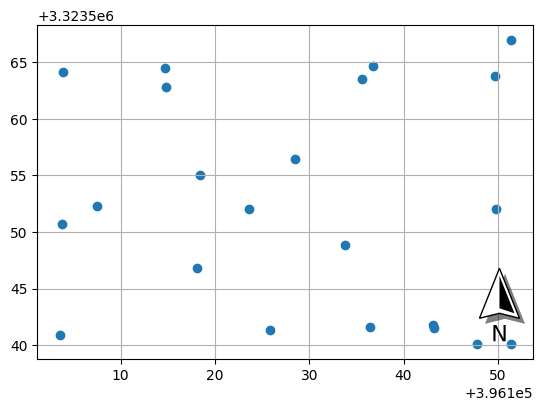

In [56]:
fig,ax = plt.subplots()
jeffas.plot(ax=ax)
plt.grid()
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.show()

<h5> Convert to UTM Z-15N NAD 1983 Datum

In [46]:
# Project everything to UTM ZOne 15N 1983(2011) Datum
projcrs = 'epsg:26915'
jeffasutm = jeffas.to_crs(projcrs)
jeffasutm.head()

,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks,geometry
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left,POINT (Infinity Infinity)
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right,POINT (Infinity Infinity)
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right,POINT (Infinity Infinity)
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left,POINT (Infinity Infinity)
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1,POINT (Infinity Infinity)


<h5> Obtain X and Y coordinates in NAD83 Datum along with As Values

In [47]:
# Obtain Lat, Lon and z values for As from Jeffasutm
x = list(jeffasutm.X)
y = list(jeffasutm.Y)
z = list(jeffasutm.Z)

<h5> Obtain Bounds to Create a Grid to Interpolate (extrapolate)

In [91]:
data = pd.read_csv(fname)

# Extract the bounds from the data
xmin, ymin = data['X'].min(), data['Y'].min()
xmax, ymax = data['X'].max(), data['Y'].max()

# Define grid size
delta = 1  # 5m x 5m grid

# Create the grid
gridx = np.arange(xmin, xmax + delta, delta)
gridy = np.arange(ymin, ymax + delta, delta)semi-variogram

# Print results
print(f"Bounds: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")
print(f"Grid X points: {len(gridx)}, Grid Y points: {len(gridy)}")

Bounds: xmin=396103.5592, ymin=3323540.109, xmax=396151.3764, ymax=3323566.964
Grid X points: 49, Grid Y points: 28


<h5> Perform Ordinary Kriging to Identify Best Variogram Model with Actual Data

The model that provides the best overall prediction of As as compared to measured data will be used here.  Ideally we would like to split the data into training and testing data and train the model with training data and test with the independent dataset.  Otherwise you could also use cross-validation.  However, here we simply use training error for simplicity.  

In [92]:
ok = OrdinaryKriging(x, y, z, variogram_model='power', verbose=False, enable_plotting=False)

In [93]:
# Perform ordinary Kriging and select the best variogram
# The best variogram gives minimum root mean sq. error
models = ['linear', 'power', 'gaussian', 'exponential', 'spherical']
varioerr = []
for m in models:
    ok = OrdinaryKriging(x, y, z, variogram_model=m, verbose=False, enable_plotting=False)
    Aspred,ss = ok.execute("grid", x, y)
    err = np.nansum((z-Aspred)**2)
    rmse = np.sqrt(err/len(z))
    varioerr.append(rmse)

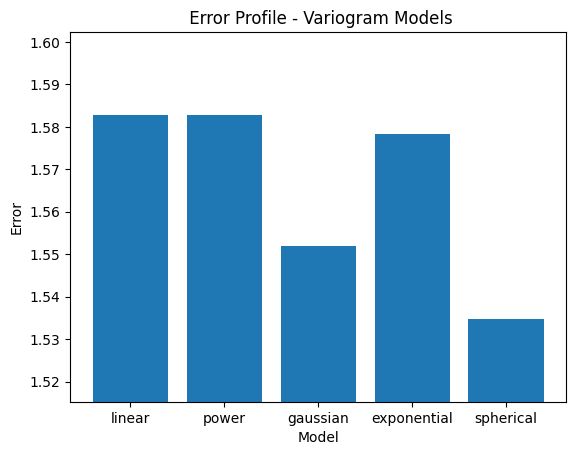

In [94]:
# Make a bar plot of errors
minlim = np.min(varioerr) - np.std(varioerr)
maxlim = np.max(varioerr) + np.std(varioerr)
plt.bar(models,varioerr)
plt.ylim(minlim,maxlim)
plt.ylabel('Error')
plt.xlabel('Model')
plt.title(' Error Profile - Variogram Models')
plt.show()

The best fit model is the Spherical Model.  But you can see any of the other models also perform closely.  (Notice the values of the Y-axis).  

<h5>  Perform Ordinary Kriging with the best fit Spherical Model on a grid

In [95]:
# Step 3: Perform ordinary kriging with Spherical Model (best fit model)
ok = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',  # Automatically fits a spherical model
    verbose=True,
    enable_plotting=False
)

# Make predictions on the grid
z_pred, ss_pred = ok.execute('grid', gridx, gridy)

# Step 4: Extract variogram information
lags = ok.lags  # Distance bins
semivariance = ok.semivariance  # Computed semivariance values

# Step 5: Compute theoretical variogram values
# Extract model parameters
model_parameters = ok.variogram_model_parameters
sill = model_parameters[0]
range_ = model_parameters[1]
nugget = model_parameters[2]

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.04978331379439023
Full Sill: 0.12042053827424126
Range: 0.8549420916211323
Nugget: 0.07063722447985103 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



<h5> Write a function for theoretial semi-variogram and Plot the empirical and theoretical variogram clouds

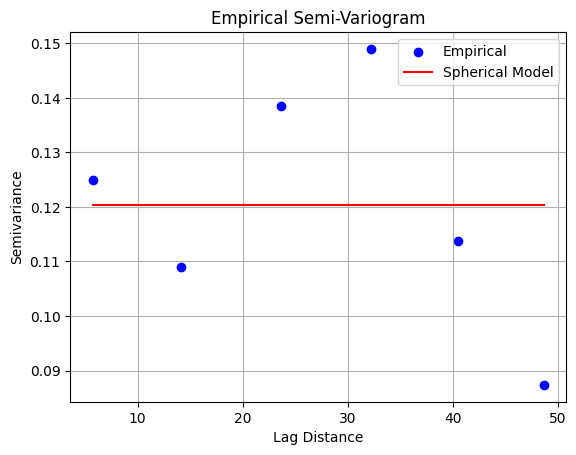

In [96]:
# Define the spherical variogram model
def spherical_variogram(h, sill, range_, nugget):
    h = np.array(h)
    gamma = np.zeros_like(h)
    mask = h <= range_
    gamma[mask] = nugget + sill * (1.5 * (h[mask] / range_) - 0.5 * (h[mask] / range_) ** 3)
    gamma[~mask] = nugget + sill
    return gamma

theoretical_variogram = spherical_variogram(lags, sill, range_, nugget)


# Extract variogram information for plotting
lags = ok.lags  # Distance bins
semivariance = ok.semivariance  # Computed semivariance values

# Step 6: Plot the empirical semi-variogram and theoretical model
plt.figure()
plt.scatter(lags, semivariance, color='blue', label='Empirical')
plt.plot(lags, theoretical_variogram, color='red', label='Spherical Model')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Empirical Semi-Variogram')
plt.grid()
plt.legend()
plt.show()

<h5> Plot the Predicted Surface on a grid

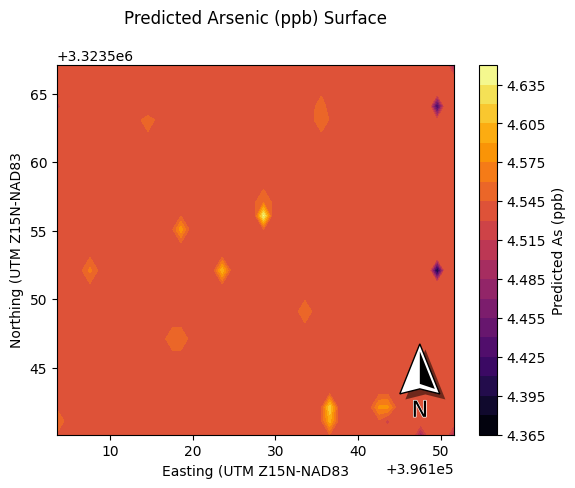

In [97]:
# Step 5: Plot the predicted surface
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, z_pred, levels=20, cmap='inferno')
#jeffutm.plot(ax=ax,facecolor='none',edgecolor='black')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.colorbar(contour, label='Predicted As (ppb)')
plt.title('Predicted Arsenic (ppb) Surface',pad=30)
plt.xlabel('Easting (UTM Z15N-NAD83')
plt.ylabel('Northing (UTM Z15N-NAD83')
plt.show()

<h5> Plot the Prediction Standard Error

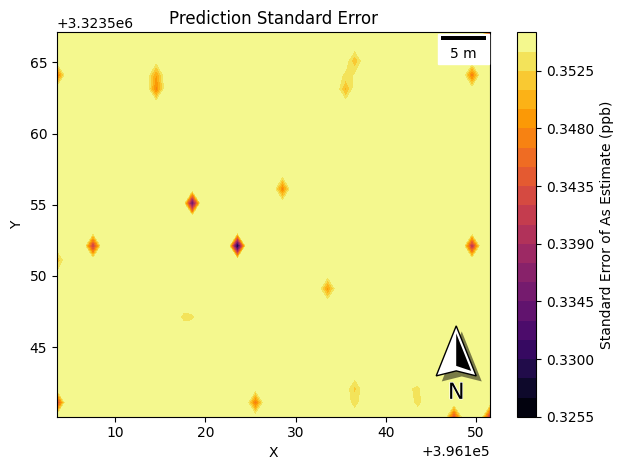

In [98]:
# Step 6: Plot the prediction standard error
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, np.sqrt(ss_pred), levels=20, cmap='inferno')
#jeffutm.plot(ax=ax,facecolor='none',edgecolor='black')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
scalebar = ScaleBar(0.001, "km")  
ax.add_artist(scalebar)
plt.colorbar(contour, label='Standard Error of As Estimate (ppb)')
plt.title('Prediction Standard Error')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

The model does near the data points but exhibits higher error when there is no data (yellow regions) A few data points near the south-east quadrant will improve predictions.

<h5> Save the Data of the Contour as an ASCII Grid File.

In [99]:
# Save Data for contour as as and ASCII grid file
write_asc_grid(gridx, gridy, z_pred,filename="Elevation.asc")

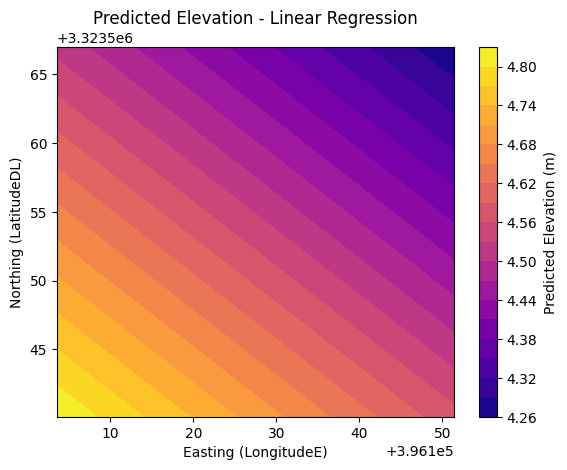

In [114]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Assume `jeffasutm` is your dataset with columns "X", "Y", and "Z"

# Extract X, Y, and Z
x = np.array(jeffasutm["X"]).reshape(-1, 1)  # Reshape for sklearn compatibility
y = np.array(jeffasutm["Y"]).reshape(-1, 1)
z = np.array(jeffasutm["Z"])

# Combine X and Y for regression
coordinates = np.hstack((x, y))

# Fit a linear regression model
model = LinearRegression()
model.fit(coordinates, z)

# Generate the linear regression predicted surface on a grid
x_range = np.linspace(x.min(), x.max(), 50).flatten()  # Ensure 1D array
y_range = np.linspace(y.min(), y.max(), 50).flatten()  # Ensure 1D array
x_mesh, y_mesh = np.meshgrid(x_range, y_range)  # Create a grid

# Predict Z values using the fitted linear regression model
z_pred_linear = (
    model.intercept_ + model.coef_[0] * x_mesh + model.coef_[1] * y_mesh
)

# Plot the predicted surface for linear regression
fig, ax = plt.subplots()
contour = ax.contourf(
    x_mesh, y_mesh, z_pred_linear, levels=20, cmap="plasma"
)
plt.colorbar(contour, label="Predicted Elevation (m)")
plt.xlabel("Easting (LongitudeE)")  # X-axis label
plt.ylabel("Northing (LatitudeDL)")  # Y-axis label
plt.title("Predicted Elevation - Linear Regression")  # Title
plt.show()


Comparing the predicted elevations from kriging and the linear regression model shows that kriging gives better results. Kriging keeps the elevation more uniform, making it easier to spot features like the hole location on the concrete pad, which we included during data collection. These features were harder to see in the linear regression model.